## Regress out cell counts from all features on a subset

In [1]:
import sys

sys.path.append("../scripts")

import numpy as np
import pandas as pd

from load import load_config
from preprocess import preprocess_profiles
from plot_utils import plot_unique_value_hist
from correct_position_effect import (
    subtract_well_mean,
    regress_out_cell_counts,
)

import seaborn as sns
from matplotlib import pyplot as plt

#### Load configs

In [2]:
cc_config = load_config("../configs/correction/regress_cell_count.yaml")
print(cc_config)
preprocess_config = load_config("../configs/preprocess")
print(preprocess_config)

{'cc_col': 'Cells_Count', 'min_unique': 100}
{'normalize_group': 'Metadata_Plate', 'normalize_kwargs': {'method': 'mad_robustize', 'mad_robustize_epsilon': 0.0, 'image_features': True}, 'feature_select_whitelist': ['Cells_Count'], 'feature_select_kwargs': {'operation': ['variance_threshold', 'correlation_threshold', 'drop_na_columns', 'blocklist'], 'unique_cut': 0.01, 'image_features': True}}


#### Load a subset of profiles

In [3]:
ann_dframe = pd.read_parquet("../1.load/output/subset_profiles.parquet")
ann_dframe

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,48.712002,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,61.765999,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,42.872002,40.491001,40.872002,40.462002,40.923000,41.264000,42.422001,41.236000,42.514000,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,51.533001,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,55.993000,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,31.225000,28.951000,29.181999,29.153999,29.162001,29.171000,30.061001,29.388000,29.938000,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,34.605999,32.294998,32.636002,32.362000,32.466000,32.683998,33.604000,32.743999,33.476002,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,30.981001,28.872999,29.042000,28.905001,29.143999,29.282000,30.084999,29.292000,30.077000,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,33.861000,31.473000,31.583000,31.374001,31.563999,31.844000,32.480000,31.665001,32.480999,2021_05_17_Batch4


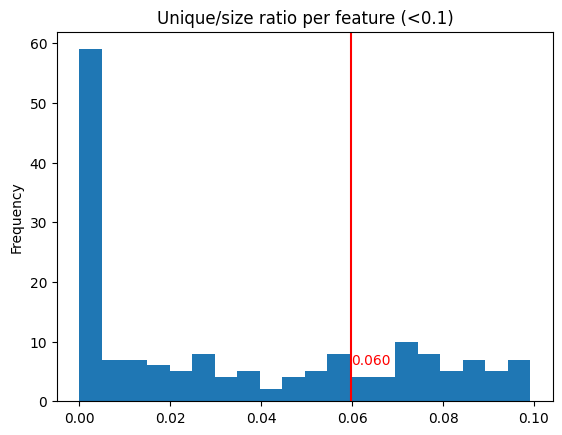

In [4]:
plot_unique_value_hist(ann_dframe, unique_ratio_cutoff=0.1, features="Cells_Count")

#### Explore correlations with cell counts

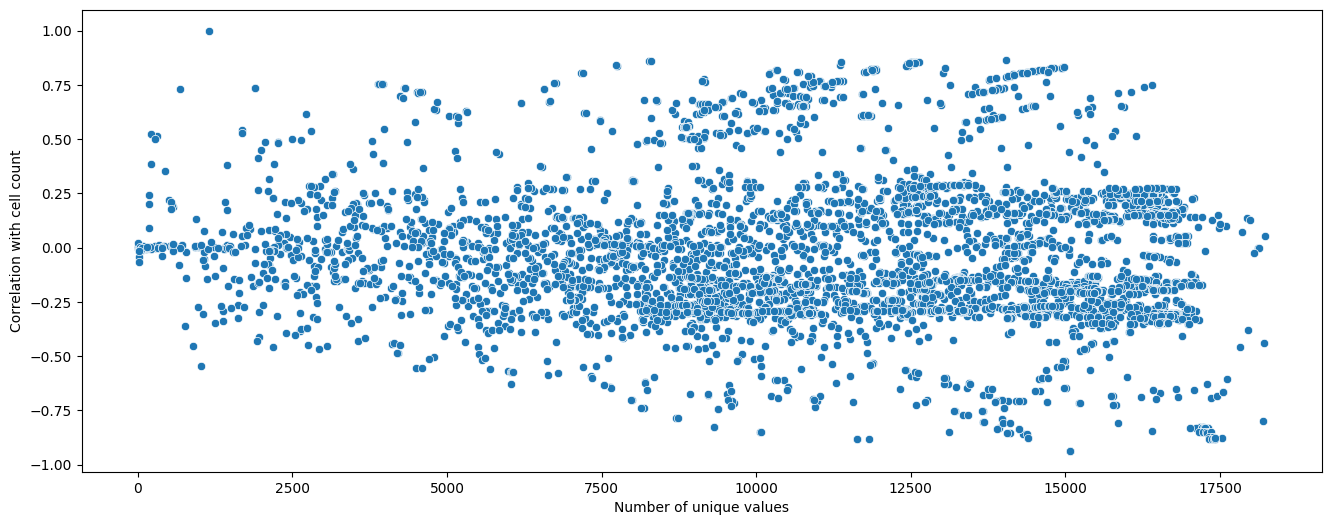

In [5]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_dframe.filter(regex="^(?!Metadata_)"),
    x=ann_dframe.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_dframe.filter(regex="^(?!Metadata_)").corrwith(ann_dframe["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [6]:
for feature in ann_dframe.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_dframe["Cells_Count"].corr(ann_dframe[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_dframe[
        feature
    ].nunique() < 1000:
        print(f"{feature}: {ann_dframe.Cells_Count.corr(ann_dframe[feature])}")

Cytoplasm_RadialDistribution_MeanFrac_AGP_3of4: -0.4552927188489635
Image_Threshold_SumOfEntropies_CellsIncludingEdges: 0.7294399617871812
Nuclei_Correlation_Manders_AGP_RNA: 0.5167498882104065
Nuclei_Correlation_Manders_ER_RNA: 0.5234919265759052
Nuclei_Correlation_Manders_Mito_RNA: 0.5013310413956075


#### Regress out cell counts only from features that have >100 unique values

In [7]:
ann_dframe = regress_out_cell_counts(ann_dframe, **cc_config)
ann_dframe

  0%|          | 0/4703 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-21.558212,-20.349036,-20.629806,-20.368307,-20.650465,-20.884252,-21.519006,-20.845826,-21.408608,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-5.083011,-5.481468,-5.539859,-5.454783,-5.611743,-5.671016,-5.737693,-5.557698,-5.461906,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-27.798565,-26.316590,-26.460330,-26.316621,-26.506019,-26.647322,-27.325564,-26.648534,-27.314382,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-16.225903,-14.790638,-14.882782,-14.753411,-14.917000,-15.024994,-15.216235,-14.950850,-15.358211,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-17.152480,-16.438301,-16.516399,-16.259854,-16.652436,-16.872302,-17.217198,-16.586266,-17.162526,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-43.267124,-41.498717,-41.820804,-41.264465,-41.947294,-42.444629,-43.481436,-42.197370,-43.696856,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-33.771634,-32.327318,-32.494047,-32.232718,-32.754854,-33.004740,-33.866642,-32.920032,-34.068495,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-39.180025,-37.448975,-37.800936,-37.388310,-37.794317,-38.135415,-39.156583,-38.099089,-39.243852,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-35.390131,-33.981802,-34.386014,-34.052681,-34.498060,-34.691437,-35.858042,-34.844936,-35.933549,2021_05_17_Batch4


#### Check if cell count has correlation above 0.5 with any feature

In [8]:
for feature in ann_dframe.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_dframe["Cells_Count"].corr(ann_dframe[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_dframe.Cells_Count.corr(ann_dframe[feature])}")

Cells_Count: 1.0


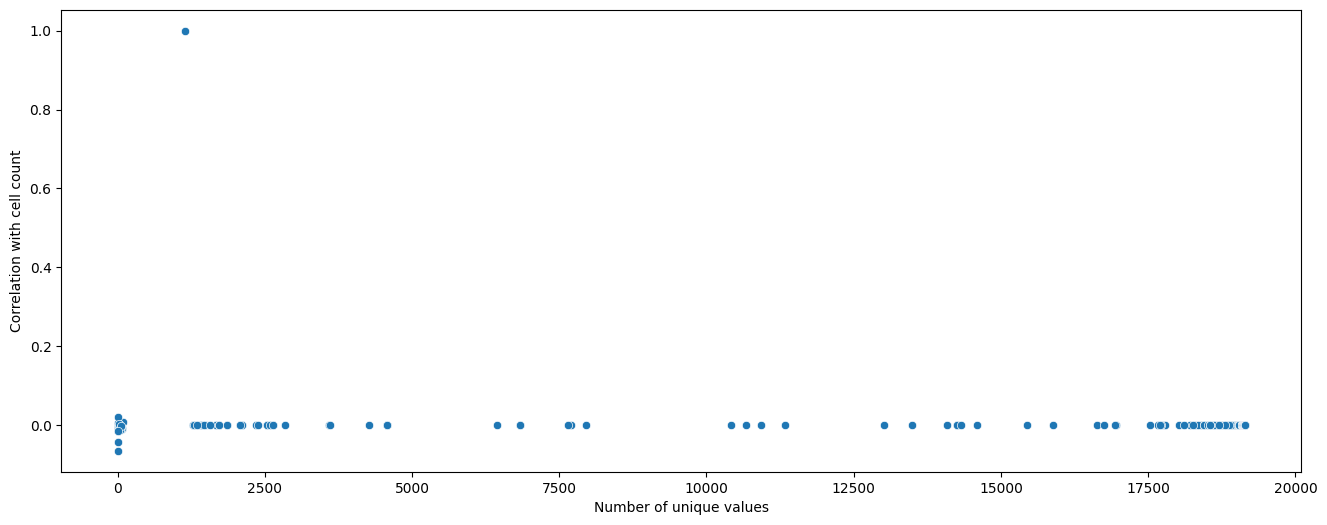

In [9]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_dframe.filter(regex="^(?!Metadata_)"),
    x=ann_dframe.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_dframe.filter(regex="^(?!Metadata_)").corrwith(ann_dframe["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Preprocess and save CC-corrected subset

In [10]:
ann_dframe_processed = preprocess_profiles(ann_dframe, **preprocess_config)
ann_dframe_processed

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_00_256,Nuclei_Texture_InfoMeas1_Mito_5_02_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900008,ccsbBroad304_00010,ORF011294.1_TRC304.1,pLX_304,NM_001278352.1,ACO1,48,9606,aconitase 1,100.0,...,-0.186120,0.224393,-0.674491,-1.546098,0.149433,-0.620143,1.537437,0.094296,0.558373,1.016925
1,JCP2022_900034,ccsbBroad304_00038,ORF001874.1_TRC304.1,pLX_304,NM_000643.2,AGL,178,9606,"amylo-alpha-1, 6-glucosidase, 4-alpha-glucanot...",100.0,...,-0.156428,-0.704158,-1.218763,-1.639803,0.437437,-1.007869,1.701927,1.100106,1.412527,1.577271
2,JCP2022_900327,ccsbBroad304_00356,ORF005713.1_TRC304.1,pLX_304,NM_001304.5,CPD,1362,9606,carboxypeptidase D,100.0,...,-0.354677,-0.406209,-0.446483,-0.972917,1.158370,0.448857,0.724587,0.056280,0.536979,-0.352811
3,JCP2022_900417,ccsbBroad304_00448,ORF010275.1_TRC304.1,pLX_304,NM_021120.4,DLG3,1741,9606,discs large MAGUK scaffold protein 3,100.0,...,-4.617327,-0.611122,-0.356669,-0.268779,1.725261,0.982674,-0.543496,1.773940,-1.640721,-0.290550
4,JCP2022_900443,ccsbBroad304_00474,ORF014835.1_TRC304.1,pLX_304,NM_001258316.1,ECT2,1894,9606,epithelial cell transforming 2,100.0,...,-0.330817,-0.469409,-0.455415,0.184663,1.380698,1.208246,-0.224822,0.470515,-0.018334,-0.477332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,0.460429,0.254158,0.109740,-0.550101,0.248344,-0.589628,0.710816,-0.191293,0.755142,0.208088
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.153905,1.002612,0.357619,0.250172,0.076972,1.129031,-0.120370,0.738204,0.343738,1.270052
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.290978,0.559867,0.534637,1.141291,-1.087403,0.860516,-1.058795,0.401875,-0.423379,1.076315
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.622801,-0.451397,0.923011,-0.613694,0.396223,-0.354869,0.294841,-1.495372,-0.966784,-1.191122


In [11]:
# check that the cell count column is still there
assert cc_config["cc_col"] in ann_dframe_processed.columns

ann_dframe_processed.to_parquet(
    "output/subset_profiles_cc_corrected.parquet", index=False
)
del ann_dframe_processed

#### Apply well mean subtraction, preprocess and save

In [12]:
ann_dframe = subtract_well_mean(ann_dframe)
ann_dframe = preprocess_profiles(ann_dframe, **preprocess_config)
ann_dframe.to_parquet("output/subset_profiles_cc_well_corrected.parquet", index=False)
ann_dframe

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_01_256,Nuclei_Texture_InfoMeas2_RNA_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Nuclei_Texture_SumVariance_ER_5_01_256,Cells_Count
0,JCP2022_900008,ccsbBroad304_00010,ORF011294.1_TRC304.1,pLX_304,NM_001278352.1,ACO1,48,9606,aconitase 1,100.0,...,-0.660863,-0.640593,-0.285272,0.352171,2.070913,0.401830,1.359302,0.401335,1.314677,2.044292
1,JCP2022_900034,ccsbBroad304_00038,ORF001874.1_TRC304.1,pLX_304,NM_000643.2,AGL,178,9606,"amylo-alpha-1, 6-glucosidase, 4-alpha-glucanot...",100.0,...,-0.981550,-0.007586,0.107507,0.586758,1.018594,1.293897,0.395957,0.831523,1.288086,1.340663
2,JCP2022_900327,ccsbBroad304_00356,ORF005713.1_TRC304.1,pLX_304,NM_001304.5,CPD,1362,9606,carboxypeptidase D,100.0,...,-0.948122,-0.556346,1.055549,0.237299,0.593432,0.445119,-0.060659,0.343763,0.547715,-0.862697
3,JCP2022_900417,ccsbBroad304_00448,ORF010275.1_TRC304.1,pLX_304,NM_021120.4,DLG3,1741,9606,discs large MAGUK scaffold protein 3,100.0,...,0.291477,-2.132254,2.137507,0.603824,0.567370,-0.125640,1.823330,-1.271891,-1.228378,-1.067237
4,JCP2022_900443,ccsbBroad304_00474,ORF014835.1_TRC304.1,pLX_304,NM_001258316.1,ECT2,1894,9606,epithelial cell transforming 2,100.0,...,-0.567500,0.512241,0.917186,-0.100734,-0.305420,0.108893,-1.286156,-0.547209,-0.849979,-0.297983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,0.202943,-0.555289,0.748625,-0.377285,0.359319,-0.417794,0.414629,0.684876,0.645168,0.025091
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.827786,-0.529451,0.345911,0.745233,0.456854,-0.061211,0.501072,1.086462,1.568625,0.955772
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,1.109917,0.820524,-1.030009,-0.081469,-1.279078,-0.466565,-0.578331,-0.049508,-0.018172,0.687664
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.851239,-0.527505,0.170551,-1.211101,-0.141527,-1.539166,0.213403,-1.762505,-1.646979,-1.591870
